In [2]:
#pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.

In [10]:
# Ejemplo univariado LSTM
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential # para construir modelos de redes neuronales de manera secuencial capa por capa.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense #cada neurona está conectada a todas las neuronas de la capa anterior.
from tensorflow.keras.layers import Flatten # Su propósito es aplanar (flatten) los datos multidimensionales de entrada en una única dimensión.
from array import array

# Función que servirá para la transformación de datos:

In [4]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):

	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		# ej = 110,125,133 es "x" / end_ix= 146
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# 1. Recopilación y exploración de datos:

Importación de serie

In [7]:
local = 'C:/Users/Josvaldes/Documents/Maestria/Austral/2ano/analisisST/TP1/SerieT/ST-main/ST-main/Datos históricos Bitcoin 2013.csv'


In [11]:
# Especifica el formato de fecha personalizado para 'Fecha' (DD.MM.YYYY)
date_parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y')

# Lee el archivo CSV con el formato de fecha personalizado
serie = pd.read_csv(local, index_col='Fecha', parse_dates=True, date_parser=date_parser)
serie = serie.asfreq('D')
serie_indice = pd.read_csv(local, parse_dates=True, date_parser=date_parser)

C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_23256\1381671639.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  serie = pd.read_csv(local, index_col='Fecha', parse_dates=True, date_parser=date_parser)
C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_23256\1381671639.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  serie_indice = pd.read_csv(local, parse_dates=True, date_parser=date_parser)


In [12]:
#Visualización de la serie de datos
serie.head()

,Último,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2013-02-01,"20,5","20,4","21,1","20,3","49,92K","0,44%"
2013-02-02,"19,6","20,5","20,5","18,0","80,50K","-4,24%"
2013-02-03,"20,6","19,6","20,9","19,4","34,24K","4,89%"
2013-02-04,"20,4","20,6","21,0","19,9","52,22K","-0,78%"
2013-02-05,"20,6","20,4","20,8","20,2","29,21K","0,83%"


In [13]:
# dimensiones del dataset
serie.shape


(3918, 6)

In [14]:
# Se eliminan datos que no son necesarios para el analisis
btc_ts=serie.drop(['Apertura','Máximo','Mínimo','Vol.','% var.'], axis=1)

In [15]:
btc_ts.head()

,Último
Fecha,
2013-02-01,"20,5"
2013-02-02,"19,6"
2013-02-03,"20,6"
2013-02-04,"20,4"
2013-02-05,"20,6"


In [16]:
# Verificamos si hay nulos
print(btc_ts.isnull().values.any())

False


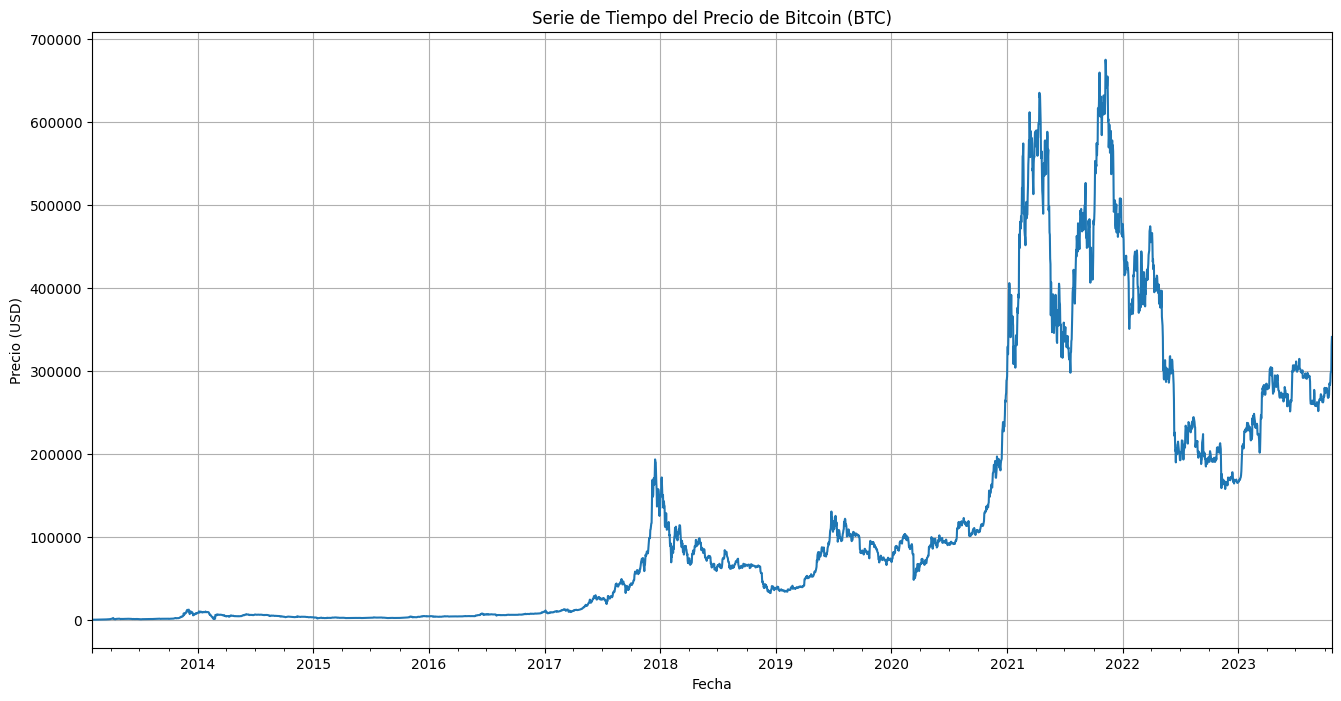

In [18]:
# Importacion para visualización
from matplotlib import pyplot as plt

# Convierte la columna 'Último' en cadenas
btc_ts['Último'] = btc_ts['Último'].astype(str)

# Reemplaza los puntos por nada (eliminar los puntos) y luego reemplaza las comas por puntos decimales
btc_ts['Último'] = btc_ts['Último'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Crea una serie de tiempo con la columna 'Último'
serie_tiempo = pd.Series(btc_ts['Último'].values, index=pd.to_datetime(btc_ts.index))

# Trama la serie de tiempo
serie_tiempo.plot(figsize=(16, 8))
plt.title('Serie de Tiempo del Precio de Bitcoin (BTC)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.grid(True)
plt.show()

El grafico hace referencia al precio del Bitcoin entre el periodo de 2014 al 2023. Los procesos de precios, por lo general, tienen un comportamiento "RANDOM WALK" (camino aleatorio). El mismo es un proceso en el que una variable cambia de manera aleatoria en cada paso de tiempo, sin seguir un patrón predecible. Es un modelo que representa cambios impredecibles en datos a lo largo del tiempo.

In [20]:
# define input sequence
timeseries_data = serie_tiempo
# choose a number of time steps
n_steps = 3
# split into samples
# preparo las variables dependientes e independientes.
X, y = prepare_data(timeseries_data, n_steps)

In [21]:
print(X)

[[2.05000e+02 1.96000e+02 2.06000e+02]
 [1.96000e+02 2.06000e+02 2.04000e+02]
 [2.06000e+02 2.04000e+02 2.06000e+02]
 ...
 [2.87230e+05 2.96745e+05 2.99129e+05]
 [2.96745e+05 2.99129e+05 2.99842e+05]
 [2.99129e+05 2.99842e+05 3.30418e+05]]


In [22]:
X.shape

(3915, 3)

In [23]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1  # para convertir X en una variable de 3 dimensiones.Este valor indica el número de características en la entrada,
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [24]:
X

array([[[2.05000e+02],
        [1.96000e+02],
        [2.06000e+02]],

       [[1.96000e+02],
        [2.06000e+02],
        [2.04000e+02]],

       [[2.06000e+02],
        [2.04000e+02],
        [2.06000e+02]],

       ...,

       [[2.87230e+05],
        [2.96745e+05],
        [2.99129e+05]],

       [[2.96745e+05],
        [2.99129e+05],
        [2.99842e+05]],

       [[2.99129e+05],
        [2.99842e+05],
        [3.30418e+05]]])

In [25]:
X.shape

(3915, 3, 1)

# 2. Construcción del modelo LSTM

In [26]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))     # return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(50, activation='relu')) - Rectified Linear Unit (o unidad lineal rectificada)
model.add(Dense(1))  # output node
model.compile(optimizer='Nadam', loss='mse') #Indica el algoritmo de descenso de gradiente que vamos a usar junto con la tasa de aprendizaje o learning_rate

# fit model
model.fit(X, y, epochs=50, verbose=1) # Epoch. Este es el numero de veces que se ejecutaran los algoritmos



Epoch 1/50

123/123 [==============================] - 2s 2ms/step - loss: 15363281920.0000
Epoch 2/50
123/123 [==============================] - 0s 2ms/step - loss: 94833168.0000
Epoch 3/50
123/123 [==============================] - 0s 2ms/step - loss: 93096848.0000
Epoch 4/50
123/123 [==============================] - 0s 2ms/step - loss: 92786008.0000
Epoch 5/50
123/123 [==============================] - 0s 2ms/step - loss: 95280208.0000
Epoch 6/50
123/123 [==============================] - 0s 2ms/step - loss: 90745680.0000
Epoch 7/50
123/123 [==============================] - 0s 2ms/step - loss: 89860344.0000
Epoch 8/50
123/123 [==============================] - 0s 2ms/step - loss: 88765224.0000
Epoch 9/50
123/123 [==============================] - 0s 2ms/step - loss: 90402512.0000
Epoch 10/50
123/123 [==============================] - 0s 2ms/step - loss: 88185584.0000
Epoch 11/50
123/123 [==============================] - 0s 2ms/step - loss: 88704080.0000
Epoch 12/50
123/123 [===

# 3. Predicción: horizonte temporal de 10 días:

In [34]:
# Output para un horizonte temporal de 10 dias

import numpy as np

x_input = np.array([299129, 299842, 330418])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):

    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1


print(lst_output)

[313111.78]
1 day input [299842.      330418.      313111.78125]
1 day output [[320271.34]]
2 day input [330418.      313111.78125 320271.34375]
2 day output [[315437.88]]
3 day input [313111.78 320271.34 315437.88]
3 day output [[316473.8]]
4 day input [320271.34 315437.88 316473.8 ]
4 day output [[314643.3]]
5 day input [315437.88 316473.8  314643.3 ]
5 day output [[314218.22]]
6 day input [316473.8  314643.3  314218.22]
6 day output [[313109.6]]
7 day input [314643.3  314218.22 313109.6 ]
7 day output [[312338.94]]
8 day input [314218.22 313109.6  312338.94]
8 day output [[311406.66]]
9 day input [313109.6  312338.94 311406.66]
9 day output [[310557.16]]
[313111.78, 320271.34, 315437.88, 316473.8, 314643.3, 314218.22, 313109.6, 312338.94, 311406.66, 310557.16]


In [35]:
timeseries_data

Fecha
2013-02-01       205.0
2013-02-02       196.0
2013-02-03       206.0
2013-02-04       204.0
2013-02-05       206.0
                ...   
2023-10-20    296745.0
2023-10-21    299129.0
2023-10-22    299842.0
2023-10-23    330418.0
2023-10-24    341061.0
Freq: D, Length: 3918, dtype: float64

In [36]:
len(timeseries_data)

3918

# 4. Vizualizamos el output

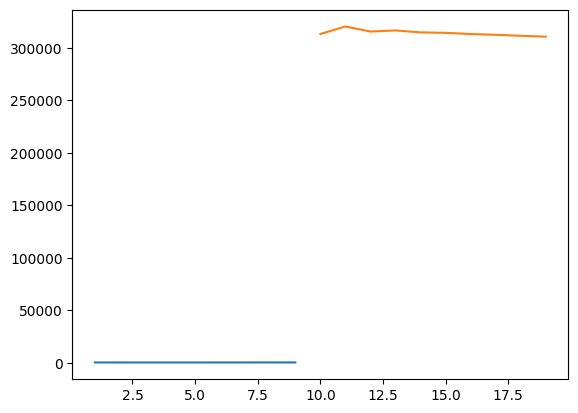

In [37]:
import matplotlib.pyplot as plt
day_new=np.arange(1,10)
day_pred=np.arange(10,20)

plt.plot(day_new,timeseries_data[:9])
plt.plot(day_pred,lst_output)

## borrar y/o analizar desde aqui

# 2. Descomposición de la serie temporal:

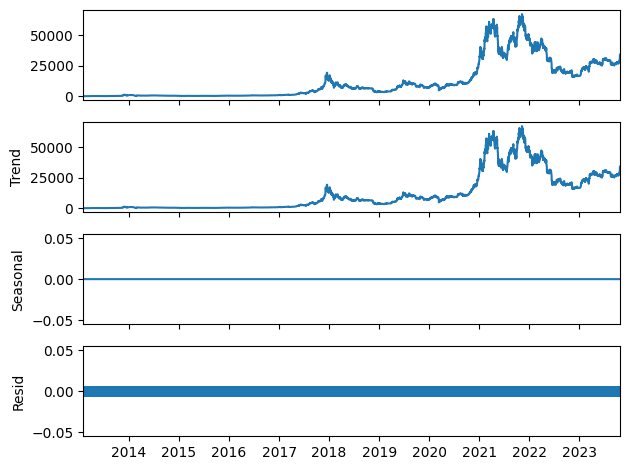

In [66]:
# descomposición de la serie
s_dec_additive = seasonal_decompose(serie_tiempo, model = "adittive",period=1)
s_dec_additive.plot()
plt.show()

Al hacer la descomposición de la serie se pueden observar 4 características:

1-	El ciclo

2-	La tendencia

3-	La estacionalidad ---> la serie no presenta esta característica. Por ello, se ve así la gráfica.

4-	No hay movimientos irregulares (el error)

Para mayor información, tanto la tendencia como la estacionalidad son componentes de NO estacionariedad. 


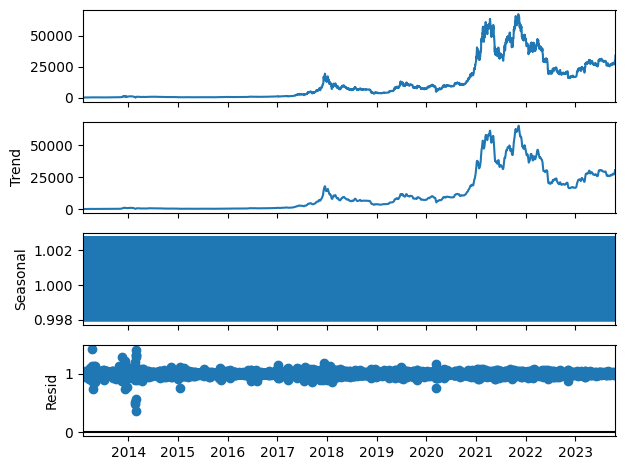

In [67]:
# descomposición multiplicativa
s_dec_multiplicative = seasonal_decompose(serie_tiempo, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

Se observa en las dos últimas graficas existencia de no estacionalidad y cierta estabilidad en los errores.

Basado en que una descomposición multiplicativa es adecuada cuando hay indicios de que la tendencia está creciendo o decreciendo de manera exponencial, podríamos inferir que para esta seria se utilizaría descomposición aditiva y no multiplicativa.


# 3. Análisis de la Estacionariedad de la serie:

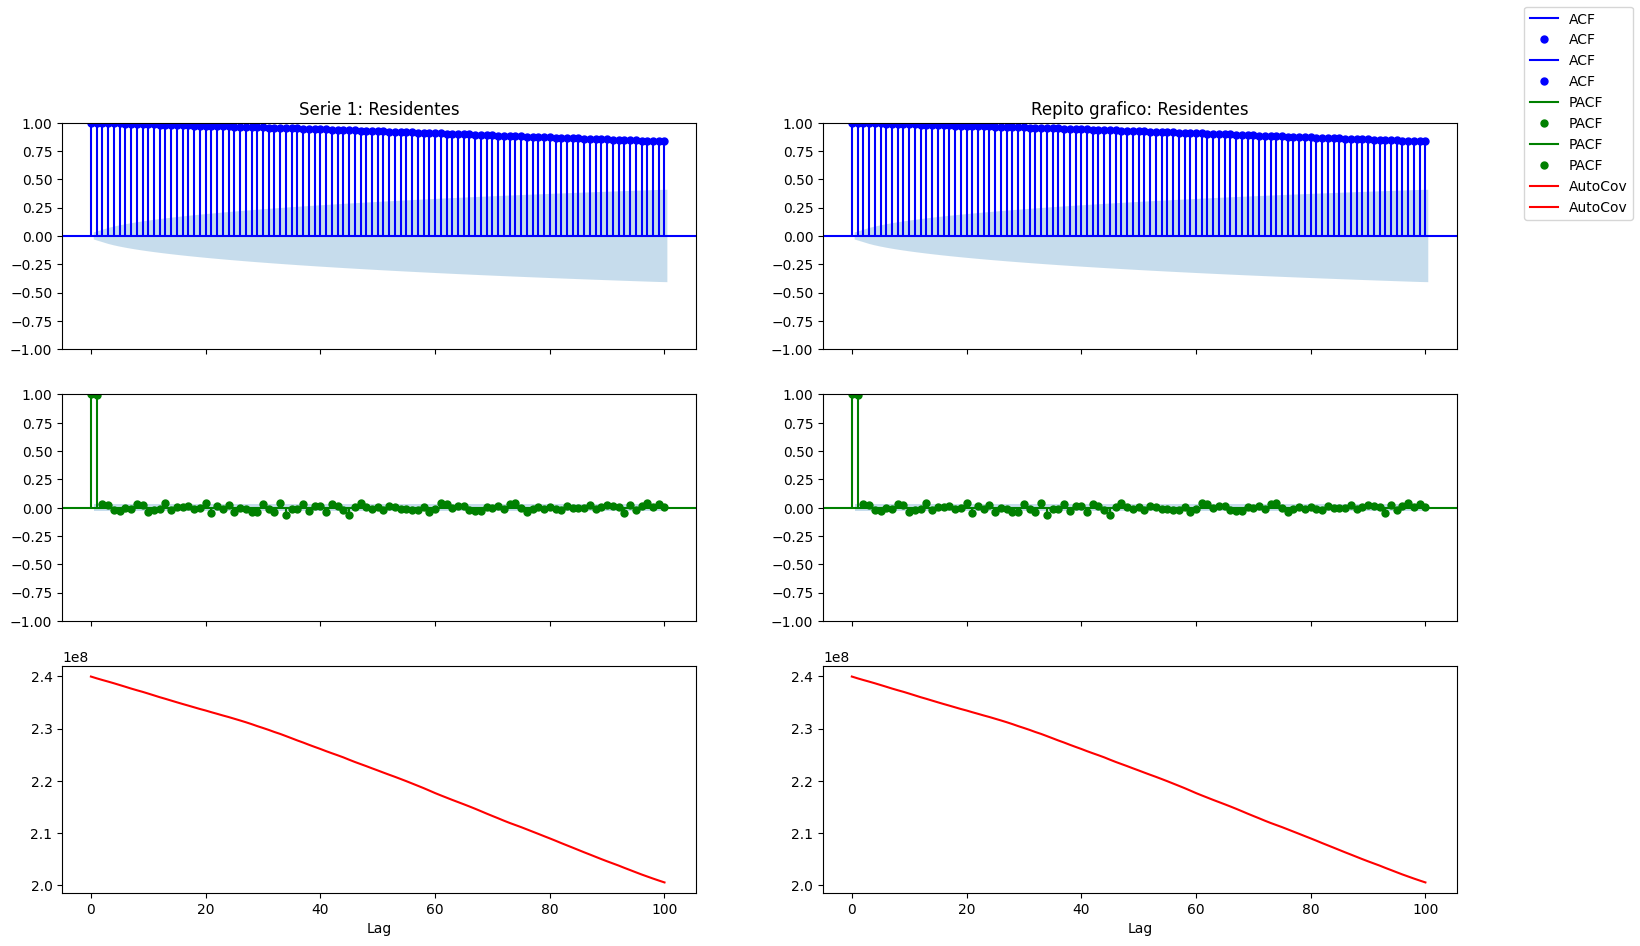

In [68]:
# Grafica diferentes funciones de la serie
autocov_autocorr(btc_ts, btc_ts ,100)

Interpretaciones de los gráficos:
- Se observan en los gráficos de autocorrelación (ACF) una linea con una una disminución gradual en la autocorrelación con el aumento de los rezagos. Esto podría sugerir un modelo autorregresivo (AR), que nos da una primera aproximación de no estacionariedad.

-Se observa en la Función de Autocorrelación Parcial (PACF) picos significativos en los primeros rezagos y luego disminuyen hacia cero. Esto sugiere que un modelo AR.

- Se observa en los graficos de la Autocovarianza que pareciera mostrar una tendencia decreciente en la autocovarianza, lo que podría indicar una tendencia en los datos.


## 3.1. Transformación de la serie

In [69]:
from scipy import stats
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
# Obtener valores de nuestra columna
btc_ts_BoxCox=btc_ts.copy()
transformacion_Box_Cox = np.asarray(btc_ts_BoxCox['Último'].values)

In [71]:
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(transformacion_Box_Cox)

C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_46656\1092230276.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformacion_Box_Cox, hist = False, kde = True,
c:\Users\Josvaldes\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_46656\1092230276.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seabo

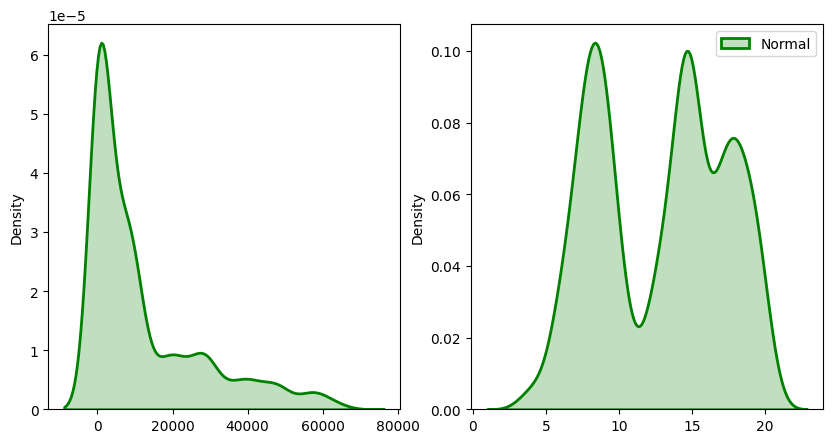

In [72]:
# creando ejes para dibujar
fig, ax = plt.subplots(1, 2)

# grafico de serie original (non-normal) y fitted data (normal)
sns.distplot(transformacion_Box_Cox, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])

# agregando leyendas a las subtramas
plt.legend(loc = "upper right")

# reescalando las subtramas
fig.set_figheight(5)
fig.set_figwidth(10)



In [73]:
print(f"Lambda value used for Transformation: {fitted_lambda}")

Lambda value used for Transformation: 0.09980728979263188


In [74]:
btc_ts_ts_BoxCox=pd.DataFrame(fitted_data, columns=['Último'])

En estadísticas, la transformación de Box-Cox se utiliza para estabilizar la varianza y hacer que los datos se ajusten mejor a supuestos de normalidad. El valor de lambda se utiliza para determinar la magnitud de la transformación.

## 3.2. Transformación logarítmica

In [75]:
btc_ts_log=btc_ts.copy()
btc_ts_log = np.log(btc_ts_log)

## 3.3. Transformación Raiz cuadrada

In [76]:
btc_ts_Rcuadrado=btc_ts.copy()
btc_ts_Rcuadrado=np.sqrt(btc_ts_Rcuadrado)

# 4. Tests

In [77]:
print_test_afd(btc_ts)

Estadistico ADF: -1.514775
p-valor: 0.526190
Valores criticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Análisis de raíz unitaria:

La prueba de raíz unitaria (ADF test, Augmented Dickey-Fuller test) que se utiliza comúnmente en econometría y análisis de series temporales para determinar si una serie temporal es estacionaria o no. Aquí está la interpretación de cada uno de estos resultados:

1-	Estadístico ADF: El estadístico ADF es el valor calculado por la prueba de raíz unitaria (ADF). Se utiliza para evaluar si una serie temporal es estacionaria. En este caso, el valor calculado es -1.660935.

2-	p-valor: El p-valor es un valor estadístico que indica la probabilidad de obtener el valor del estadístico ADF (o uno más extremo) si la serie temporal fuera en realidad no estacionaria. En este caso, el p-valor es 0.451344. Un p-valor alto, como en este caso, sugiere que no se rechaza la hipótesis nula de que la serie temporal es no estacionaria, lo que significa que la serie no es estacionaria en este nivel de significancia.

3-	Valores críticos: Los valores críticos son umbrales que se utilizan para comparar el estadístico ADF calculado. Si el estadístico ADF es más negativo (en términos absolutos) que estos valores críticos, se puede rechazar la hipótesis nula de que la serie es no estacionaria. En este caso, se proporcionan valores críticos para tres niveles de significancia:
•	1%: -3.488
•	5%: -2.887
•	10%: -2.580

La comparación entre el estadístico ADF y los valores críticos es fundamental para determinar si la serie temporal es estacionaria. En este caso, como el estadístico ADF es menos negativo (más cercano a cero) que los valores críticos, no se rechaza la hipótesis nula, lo que sugiere que la serie temporal es no estacionaria en esos niveles de significancia.
Se concluye que los resultados indican que la serie temporal analizada no es estacionaria a los niveles de significancia del 1%, 5% y 10%, ya que el estadístico ADF es menos negativo que los valores críticos correspondientes y el p-valor es alto. Esto significa que la serie temporal podría requerir transformaciones adicionales o diferenciación para hacerla estacionaria.

Por el test de raíz unitaria Dickey-Fuller la serie analizada no es estacionaria.



In [78]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(btc_ts, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-0.7926858858769108,
 0.3735895789090086,
 31,
 3886,
 {'1%': -2.5663155875837593,
  '5%': -1.9410693422185703,
  '10%': -1.6167518313754257},
 62121.32057648924)

Prueba de raíz unitaria (ADF test, Augmented Dickey-Fuller test) realizada sobre una serie de tiempo, en este caso, btc_ts. Esta prueba se utiliza para determinar si una serie de tiempo es estacionaria o no. A continuación, se proporciona la interpretación de los resultados de la prueba:

1-	Estadístico ADF (-0.9424251146220971): Este valor es el resultado del estadístico ADF calculado durante la prueba. Es un número real y se utiliza para evaluar si la serie de tiempo es estacionaria o no. En este caso, el valor calculado es -0.9424251146220971.

2-	P-valor (0.311414622285823): El p-valor es otro resultado importante de la prueba. Representa la probabilidad de obtener el estadístico ADF calculado (o uno más extremo) si la serie de tiempo fuera en realidad no estacionaria. En este caso, el p-valor es 0.311414622285823. Un p-valor alto, como en este caso, sugiere que no se rechaza la hipótesis nula de que la serie de tiempo es no estacionaria. Esto significa que la serie de tiempo podría no ser estacionaria a un nivel de significancia común.

3-	Número de retrasos utilizados (11): En esta prueba se utilizan un número de retrasos para calcular el estadístico ADF. En este caso, se utilizaron 11 retrasos.

4-	Número de observaciones utilizadas (117): Indica el número de observaciones en la serie de tiempo utilizadas en el cálculo de la prueba.

5-	Valores críticos: Los valores críticos se utilizan para comparar el estadístico ADF calculado con umbrales que indican si la serie de tiempo es estacionaria. En este caso, se proporcionan los valores críticos para tres niveles de significancia: 1%, 5% y 10%. Si el estadístico ADF es más negativo (en términos absolutos) que estos valores críticos, se podría rechazar la hipótesis nula de no estacionariedad.

6-	Estadístico de información de Akaike (AIC) (2236.049205527529): El valor del AIC es una medida de la información que se utiliza en la estimación de modelos estadísticos. En este contexto, indicar información sobre la calidad del ajuste del modelo.

En conclusión, los resultados sugieren que la serie de tiempo btc_ts podría no ser estacionaria, ya que el p-valor es alto y el estadístico ADF es menos negativo que los valores críticos correspondientes. Esto implica que es posible que la serie de tiempo requiera alguna transformación o diferenciación para hacerla estacionaria antes de aplicar modelos de análisis de series temporales.

Nota: La prueba se realiza sin constante en el modelo de regresión.

In [79]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(btc_ts, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-1.5147751024597818,
 0.5261900575970339,
 31,
 3886,
 {'1%': -3.4320338972900073,
  '5%': -2.8622840535779,
  '10%': -2.5671660686699074},
 62121.20763707632)

Se observa que incluyendo en el test el termino independiente se sigue llegan a la conclusión de que la seria no es estacionaria como en el punto anterior en el que no se tenía termino independiente.

In [80]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(btc_ts, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-2.766734598888383,
 0.20943051926522172,
 31,
 3886,
 {'1%': -3.9611015554234066,
  '5%': -3.411620398423804,
  '10%': -3.1277156231389727},
 62117.66839897564)

Esta opción significa que la prueba de raíz unitaria incluye tanto un término constante (intercepto) como una tendencia lineal en el modelo de regresión. Esto se utiliza para modelar una tendencia lineal en los datos. Se observa que en este caso se sugiere que la serie de tiempo podría ser estacionaria en el nivel de significancia común, aunque por p-valor se descartaría.

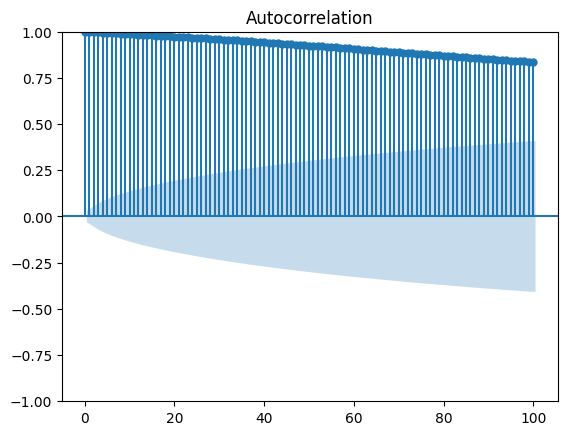

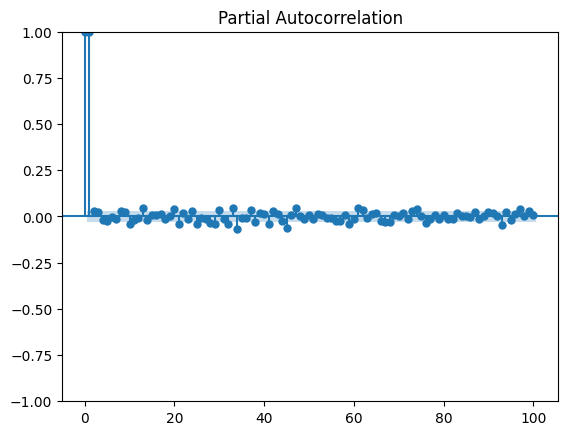

In [81]:
plot_acf(btc_ts,lags=100);
plot_pacf(btc_ts,lags=100);

In [82]:
# Validación de la estacionariedad de la serie a través de la función definida inicialmente
estacionario(btc_ts)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.42557499207622074, True)


## 4.1. Otras pruebas de hipótesis para poner a prueba la conjetura de Raíz Unitaria.

In [83]:
from arch.unitroot import PhillipsPerron

In [84]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Incluya término independiente pero no incluye término lineal',
              'ct':'Incluya ambos términos'
              }
    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')
        pp = PhillipsPerron(series,trend=param, **k)
        print(f'PP Estadistico: {pp.stat}')
        print(f'p-valor: {pp.pvalue}')
        print(f'numero de lags: {pp.lags}')
        print('Valor Critico:')
        for key, value in pp.critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if pp.pvalue > 0.05 else ""}estacionaria')
        print(f"PP Numero de diferenciacion estimada: {ndiffs(series, test='pp')}")

        print("*".center(60, '*'))
        print("")

In [85]:
Phillips_Perron(btc_ts)

Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -0.5856076789307718
p-valor: 0.4606407493083155
numero de lags: 31
Valor Critico:
   1% : -2.566311030371138
   5% : -1.9410687916877225
   10% : -1.6167523694725703
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -1.3002704627380177
p-valor: 0.6290485675665064
numero de lags: 31
Valor Critico:
   1% : -3.43202056180743
   5% : -2.862278162762053
   10% : -2.567162932634786
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: ct - Incluya ambos términos
PP Estadistico: -2.4280336500383526
p-valor: 0.36482456823399706
numero de lags: 31
Valor Critico:
   1% : -3.9610830881641275
   5% : -3.4116114474916595
   10

## 4.2. KPSS

In [86]:
from statsmodels.tsa.stattools import kpss

In [87]:
def kpss_test(series, **kw):

    params = {'c':'Los datos son estacionarios alrededor de una constante.',
              'ct': 'Los datos son estacionarios alrededor de una tendencia.'
             }

    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')

        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        # Format Output
        print(f'KPSS Estadistico: {statistic}')
        print(f'p-valor: {p_value}')
        print(f'numero de lags: {n_lags}')
        print('Valor critico:')
        for key, value in critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if p_value < 0.05 else ""}estacionaria')
        print(f"KPSS Numero estimado de diferencias a aplicar: {ndiffs(series, test='kpss')}")

        print("*".center(60, '*'))
        print("")

In [88]:
kpss_test(btc_ts)

Tipo de regresión: c - Los datos son estacionarios alrededor de una constante.
KPSS Estadistico: 6.291702004937348
p-valor: 0.01
numero de lags: 39
Valor critico:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************

Tipo de regresión: ct - Los datos son estacionarios alrededor de una tendencia.
KPSS Estadistico: 0.6561192060910974
p-valor: 0.01
numero de lags: 39
Valor critico:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************



C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_46656\2551453940.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_46656\2551453940.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)


Se valida con las transformaciones realizadas

In [89]:
print_test_afd(btc_ts_BoxCox)

Estadistico ADF: -1.514775
p-valor: 0.526190
Valores criticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [90]:
estacionario(btc_ts_BoxCox)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.42557499207622074, True)


In [91]:
print_test_afd(btc_ts_log)

Estadistico ADF: -2.176973
p-valor: 0.214709
Valores criticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [92]:
estacionario(btc_ts_log)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.25842196415173657, True)


In [93]:
print_test_afd(btc_ts_Rcuadrado)

Estadistico ADF: -0.941300
p-valor: 0.774068
Valores criticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [94]:
estacionario(btc_ts_Rcuadrado)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.46519205721397927, True)


Se observa que las transformaciones no dejan la seria estacionaria, se debe proceder con la diferenciación de la misma.

# 5. Diferenciación de la serie

In [95]:
#Diferenciación de la serie en un período

btc_ts_diff=btc_ts.copy()
btc_ts_diff=btc_ts_diff.diff(axis=0, periods = 1)
btc_ts_diff=btc_ts_diff.dropna()


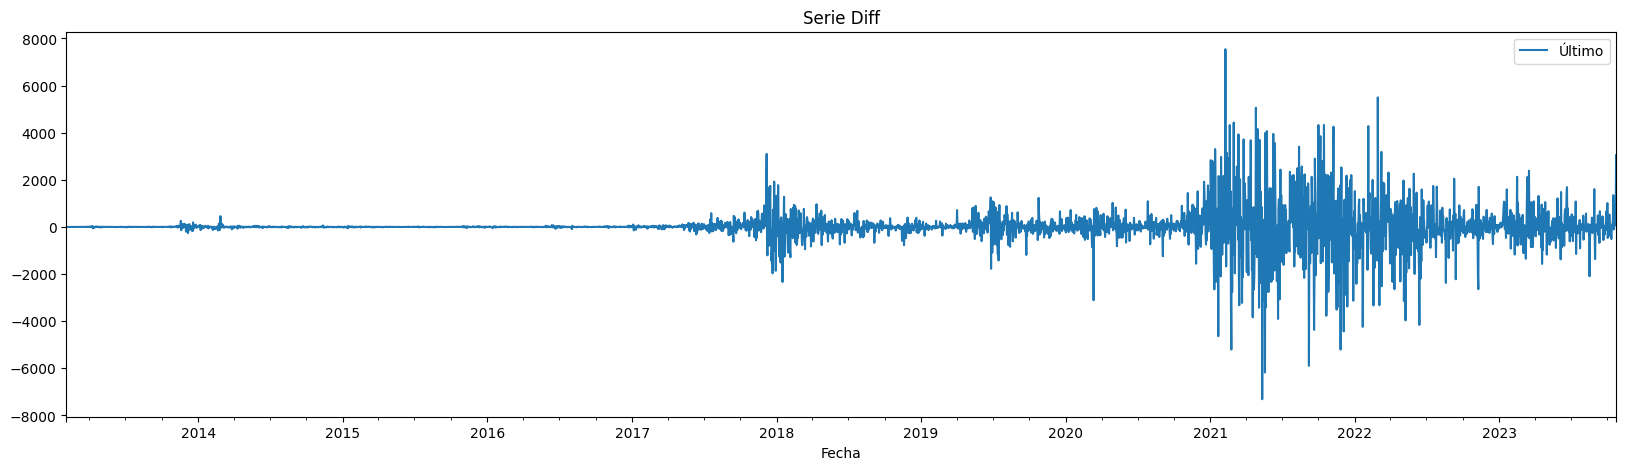

In [96]:
#Visualización serie diferenciada

btc_ts_diff.plot(figsize=(20,5), title = "Serie Diff")
plt.show()

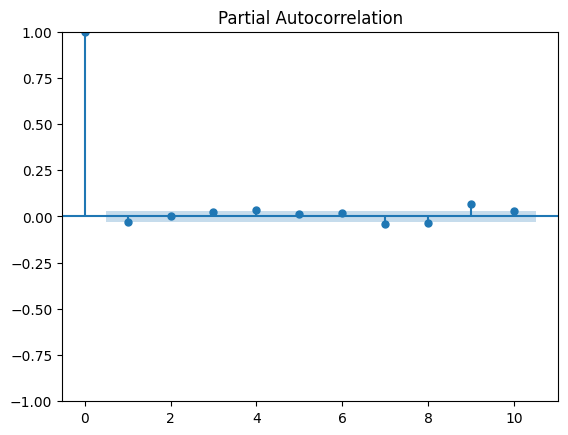

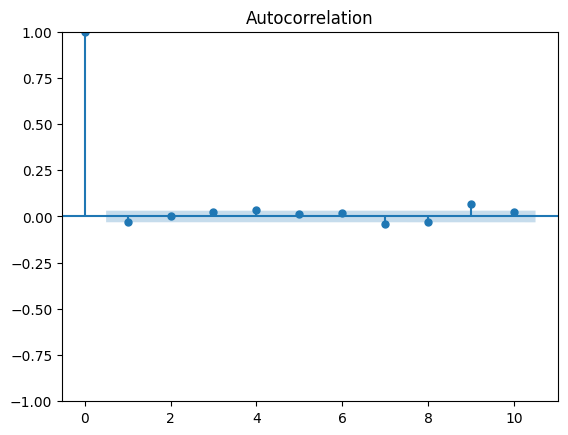

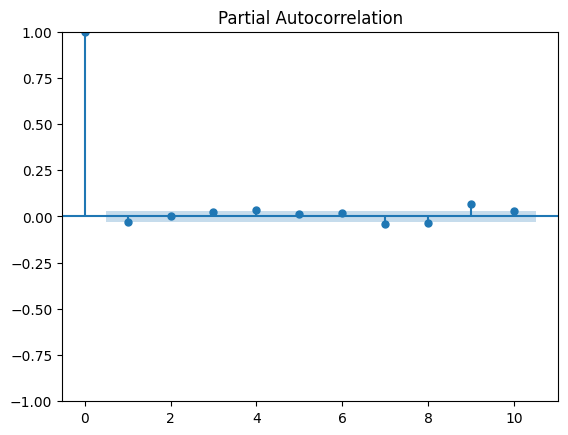

In [97]:
# Grafico autocorrelación y autocorrelación parcial de la serie diferenciada

plot_acf(btc_ts_diff, lags=10)
plot_pacf(btc_ts_diff, lags=10)

In [98]:
estacionario(btc_ts_diff)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


Se observa que la serie diferenciada es estacionaria, por lo que se puede aplicar un modelo ARIMA.

## 5.1. Opción de diferenciación 2

In [99]:
#Diferenciación de la serie en un período

btc_ts_diff_opcion_2=btc_ts.copy()
btc_ts_diff_opcion_2=btc_ts_diff_opcion_2-btc_ts_diff_opcion_2.shift(1)
btc_ts_diff_opcion_2=btc_ts_diff_opcion_2.dropna()

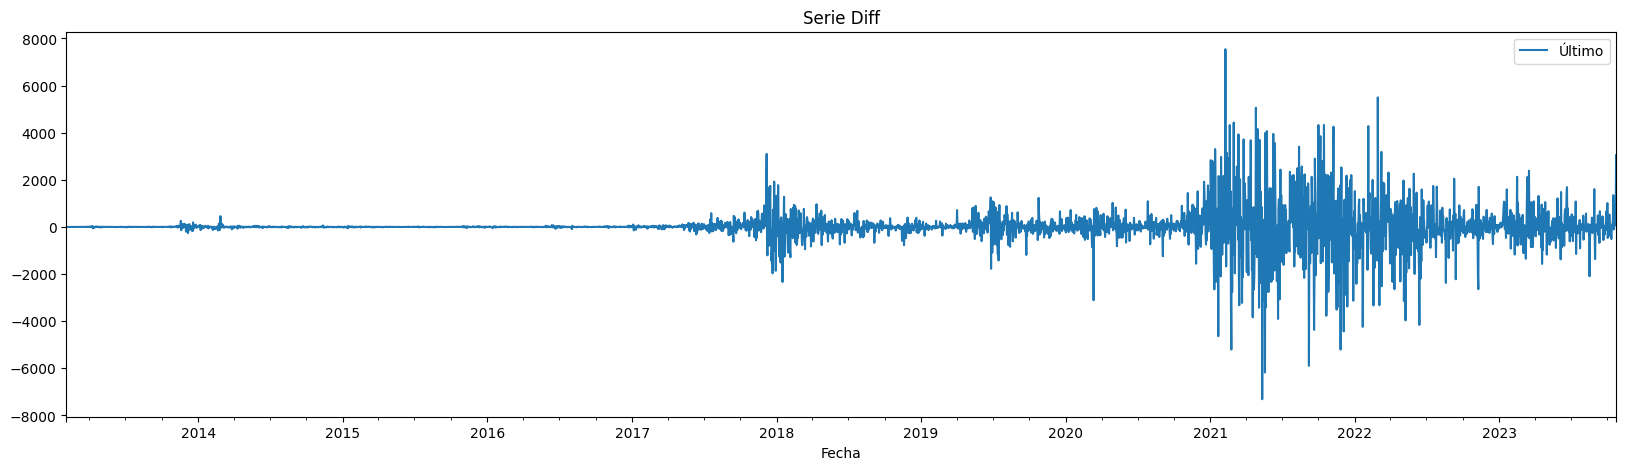

In [100]:
#Visualización serie diferenciada

btc_ts_diff_opcion_2.plot(figsize=(20,5), title = "Serie Diff")
plt.show()

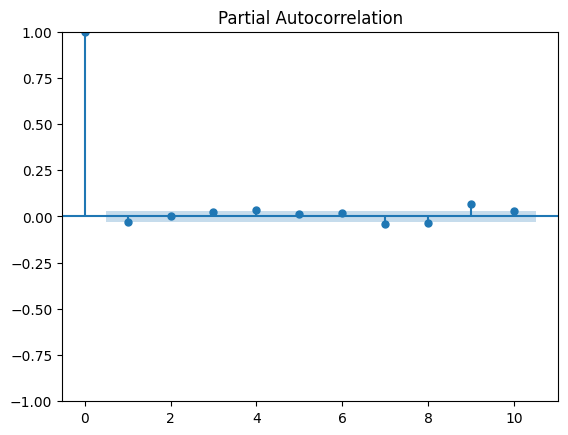

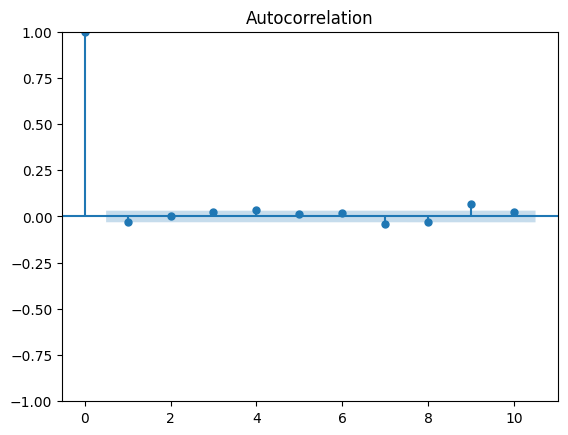

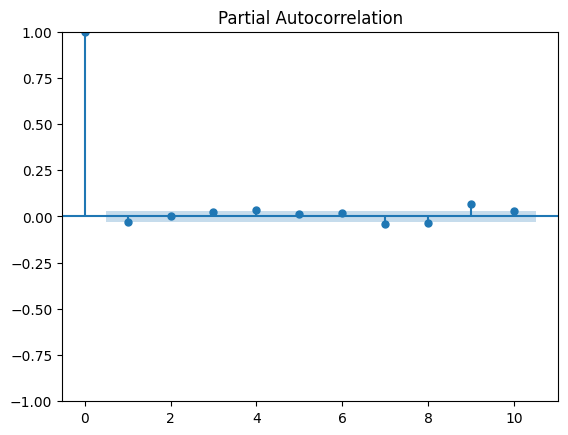

In [101]:
# Grafico autocorrelación y autocorrelación parcial de la serie diferenciada

plot_acf(btc_ts_diff_opcion_2, lags=10)
plot_pacf(btc_ts_diff_opcion_2, lags=10)

In [102]:
estacionario(btc_ts_diff_opcion_2)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


Se observa que con esta segunda opción de diferenciación de la serie se logra la estacionalidad.

## 5.2. Opción de diferenciación 3

In [103]:
#Diferenciación de la serie en 12 períodos

btc_ts_diff_opcion_3=btc_ts.copy()
btc_ts_diff_opcion_3=btc_ts_diff_opcion_3-btc_ts_diff_opcion_3.shift(12)
btc_ts_diff_opcion_3=btc_ts_diff_opcion_3.dropna()

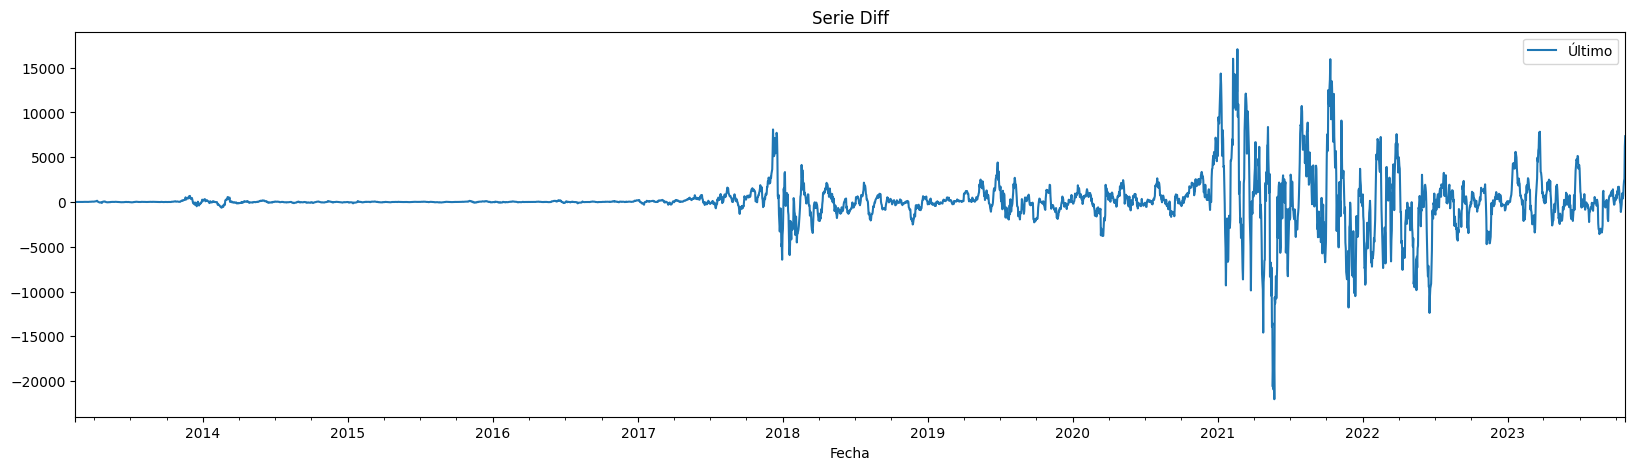

In [104]:
#Visualización serie diferenciada

btc_ts_diff_opcion_3.plot(figsize=(20,5), title = "Serie Diff")
plt.show()

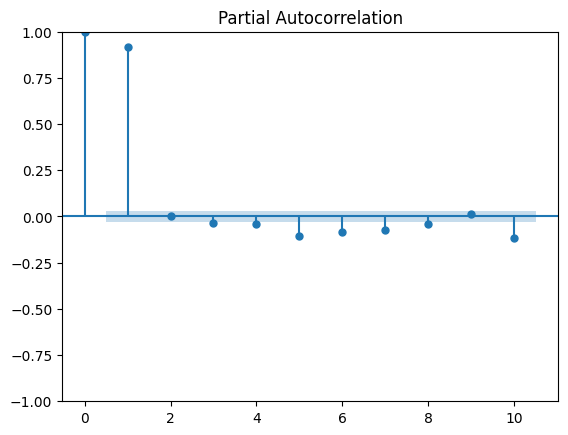

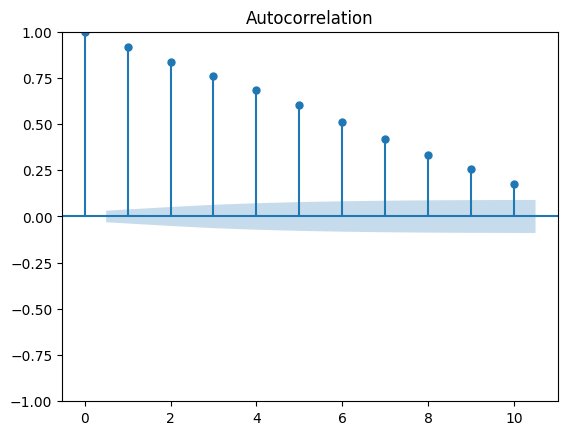

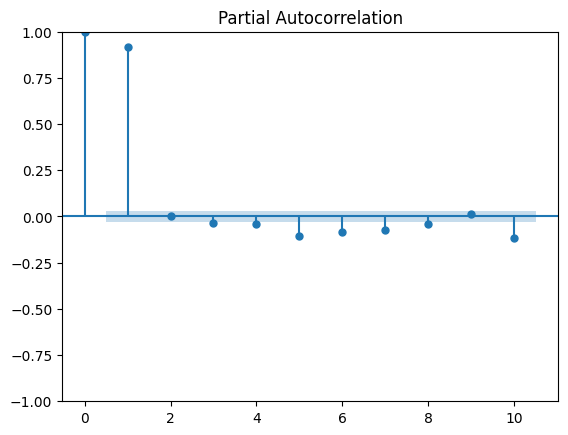

In [105]:
# Grafico autocorrelación y autocorrelación parcial de la serie diferenciada

plot_acf(btc_ts_diff_opcion_3, lags=10)
plot_pacf(btc_ts_diff_opcion_3, lags=10)

In [106]:
estacionario(btc_ts_diff_opcion_3)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


Se observa que con esta tercera opción de diferenciación de la serie se logra la estacionalidad tambien.

# 6. Modelado de la serie:

In [140]:
# se trabaja con la primera opción que mostro estacionariedad de la serie, se recalca que se podría usar la opción 2 y 3 que también mostraron estacionariedad.
# se debe validar los resultados con la serie original debido a que la diferenciada mostro una graficas de predicción raras, pendiente volver a revisar.
model = sm.tsa.arima.ARIMA(btc_ts, order=(1,0,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Último   No. Observations:                 3918
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -31351.014
Date:                Sat, 11 Nov 2023   AIC                          62708.029
Time:                        08:36:20   BIC                          62726.849
Sample:                    02-01-2013   HQIC                         62714.707
                         - 10-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.2e+04     55.852    214.799      0.000    1.19e+04    1.21e+04
ar.L1          0.9991      0.000   2807.443      0.000       0.998       1.000
sigma2      5.214e+05   3528.548    147.758      0.000    5.14e+05    5.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.42   Jarque-Bera (JB):             67974.43
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):            1259.40   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.37e+17. Standard errors may be unstable.
"""

In [141]:
stepwise_fit = auto_arima(btc_ts, trace=True,suppress_warnings=True)
#autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=62662.490, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62685.115, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62683.571, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62683.607, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62683.684, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=62685.398, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62687.509, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=62664.324, Time=2.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=62664.360, Time=2.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62685.561, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=62683.256, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=62683.893, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=62666.186, Time=2.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=62661.065, Time=1.28 sec
 ARIMA(1,1,2)(0,0,0

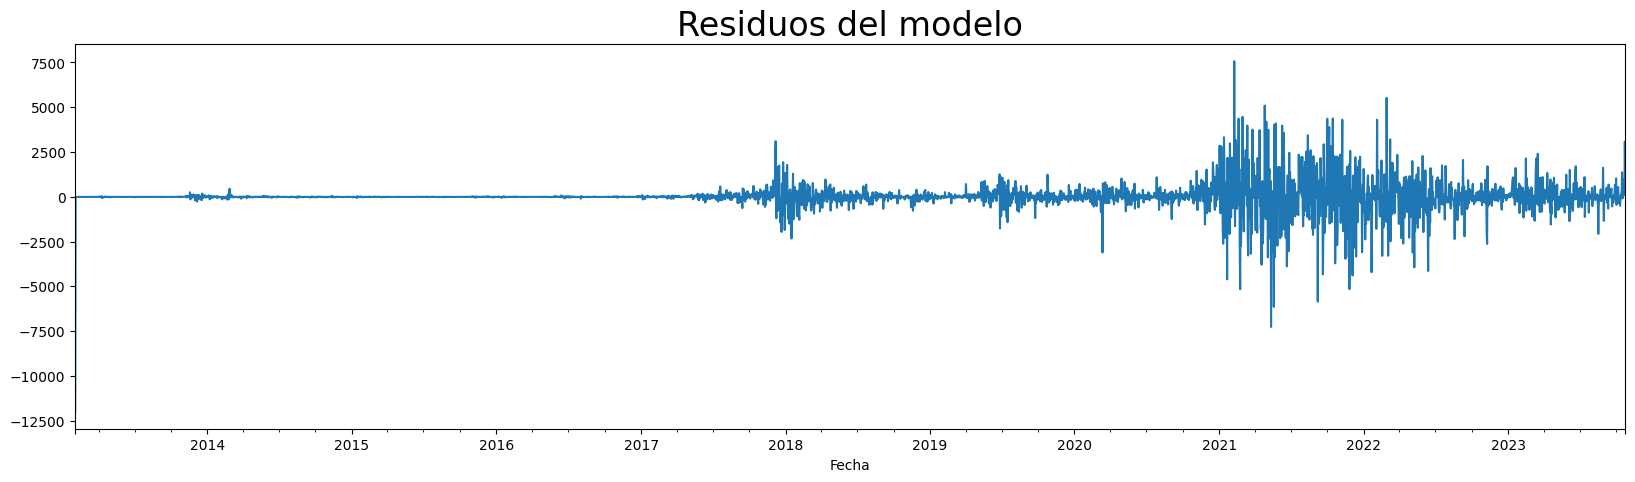

In [142]:
result.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

C:\Users\Josvaldes\AppData\Local\Temp\ipykernel_46656\4187005851.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result.resid,bins=12,color='#fcba03')


Text(0.5, 1.0, 'Histograma de los residuos del modelo')

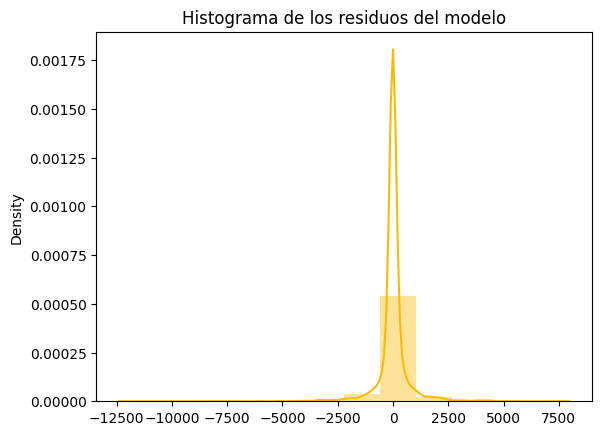

In [143]:
sns.distplot(result.resid,bins=12,color='#fcba03')
plt.title('Histograma de los residuos del modelo')

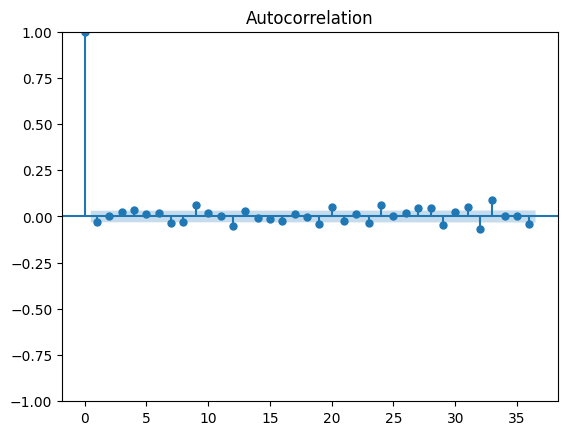

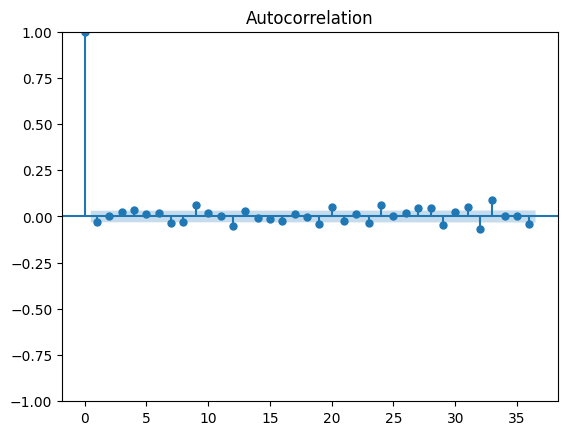

In [144]:
plot_acf(result.resid)

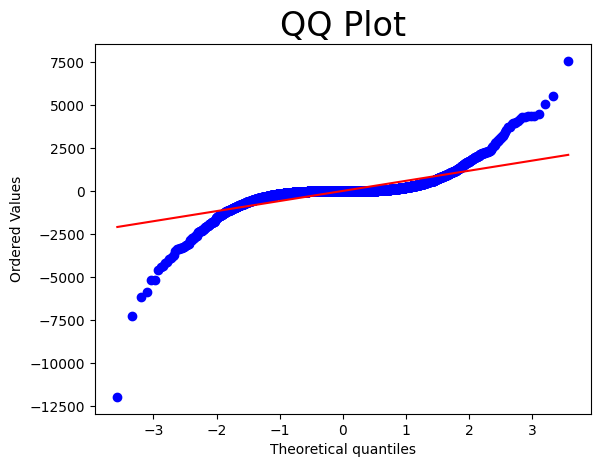

In [145]:
import scipy
import pylab

scipy.stats.probplot(result.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

In [113]:
import statsmodels.api as sm
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(result.resid, lags=30)
Incorr_residuos_modelo

,lb_stat,lb_pvalue
1,0.000036,9.951906e-01
2,0.073843,9.637516e-01
3,2.619254,4.541240e-01
4,7.570571,1.086374e-01
5,8.307270,1.400947e-01
6,9.815705,1.326307e-01
7,16.402103,2.168614e-02
8,20.029030,1.022678e-02
9,38.396773,1.479372e-05
10,40.773275,1.237609e-05


Text(0, 0.5, 'P-valores ')

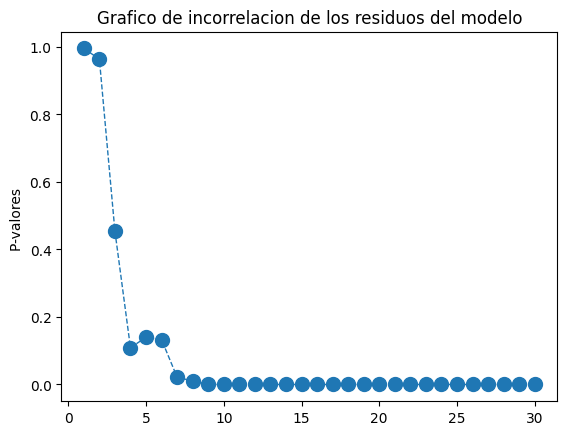

In [146]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

In [147]:
stepwise_model2 = auto_arima(btc_ts, seasonal=True, m=12)
forecast,conf_int = stepwise_model2.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
#df_conf["new_index"] = range(6246, 6276)
#df_conf = df_conf.set_index("new_index")

In [148]:
my_array = np.array(conf_int)

df = pd.DataFrame(my_array, columns = ['Limite_Inferior','Limite_Superior'])

print(df)
print(type(df))

    Limite_Inferior  Limite_Superior
0      32687.395159     35517.796737
1      32151.455202     36103.187451
2      31807.957291     36608.031140
3      31355.572174     36895.897446
4      30950.243403     37172.552128
5      30658.828433     37501.319263
6      30401.987214     37793.666346
7      30191.869861     38075.371447
8      29994.827215     38342.127557
9      29719.320190     38523.120384
10     29277.720834     38528.328122
11     28998.037270     38669.857730
12     28824.889703     38855.066175
13     28732.057871     39101.781409
14     28580.680612     39286.428895
15     28435.519522     39478.748117
16     28231.721471     39605.203591
17     28025.870791     39711.967458
18     27918.587979     39900.123191
19     27854.605501     40124.628183
20     27722.653842     40282.838048
21     27565.872071     40416.270553
22     27571.487617     40703.362550
23     27512.617590     40912.234316
24     27428.756346     41112.965279
25     27292.975725     41259.180763
2

In [149]:
import datetime
import pandas as pd
start = datetime.datetime.strptime("2023-10-01", "%Y-%m-%d")
date_generated = pd.date_range(start, periods=len(df), freq='b')
print(date_generated.strftime("%Y-%m-%d"))

Index(['2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06',
       '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
       '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
       '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
       '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03',
       '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10'],
      dtype='object')


In [150]:
df['Periodos'] = np.array(date_generated)

In [151]:
df.set_index("Periodos", inplace=True)

In [152]:
df['forecast']=forecast.close_pred

df.head()

,Limite_Inferior,Limite_Superior,forecast
Periodos,,,
2023-10-02,32687.395159,35517.796737,NaN
2023-10-03,32151.455202,36103.187451,NaN
2023-10-04,31807.957291,36608.031140,NaN
2023-10-05,31355.572174,36895.897446,NaN
2023-10-06,30950.243403,37172.552128,NaN


## 6.1. Grafica de predicción

In [153]:
# Función para graficar

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="BTC"):
    fig_x = plt.figure(figsize=(12, 3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones con etiquetas
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos con etiquetas
    conf_int.iloc[:, 1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:, 0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)

    # Agregamos la leyenda con loc="best" para que se coloque automáticamente en la mejor posición
    axes_x.legend(loc="best")
    axes_x.grid(True, color='0.6', dashes=(5, 2, 1, 2))
    plt.show()

In [154]:
#Función para evaluar los modelos contra el test en MSE, MAE, RMSE, MAPE

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [155]:
# Separacion Train/Test
# Seleccionamos el primer 80% para train
train = btc_ts.iloc[:round(len(btc_ts)*.80)]

# Seleccionamos el 20% restante para test
test = btc_ts.iloc[round(len(btc_ts)*.80):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

             Último
Fecha              
2013-02-01     20.5
2013-02-02     19.6
2013-02-03     20.6
2013-02-04     20.4
2013-02-05     20.6
...             ...
2021-08-27  49064.3
2021-08-28  48897.1
2021-08-29  48777.4
2021-08-30  46992.7
2021-08-31  47130.4

[3134 rows x 1 columns]              Último
Fecha              
2021-09-01  48819.4
2021-09-02  49274.3
2021-09-03  49999.0
2021-09-04  49918.4
2021-09-05  51768.6
...             ...
2023-10-20  29674.5
2023-10-21  29912.9
2023-10-22  29984.2
2023-10-23  33041.8
2023-10-24  34106.1

[784 rows x 1 columns]


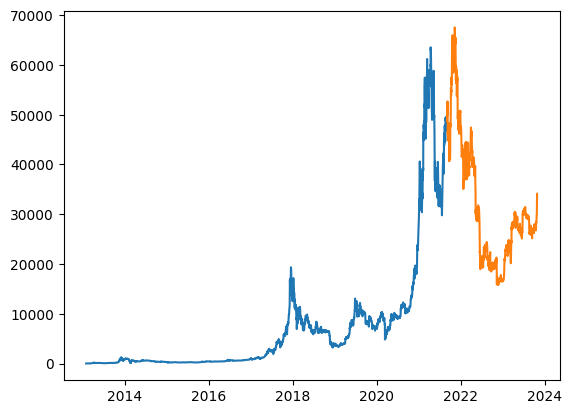

In [156]:
# Visualización Train - Test

plt.plot(train)
plt.plot(test)

In [157]:
# Usamos la funcion auto_arima del paquete pmdarima para optimizar la combinacion de hiperparametros para el modelo ARIMA

auto_arima(train, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=True, m=7, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=48982.691, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=48970.988, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=48973.027, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=48982.655, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=48969.295, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=48970.955, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=48971.345, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=48955.014, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=48956.625, Time=0.27 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=48956.593, Time=1.40 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=48957.363, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[7] intercept   : AIC=48952.885, Time=0.15 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=48954.108, Time=0.41 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=48954.038, Time=0.32 sec
 ARIMA(3,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3134
Model:               SARIMAX(4, 1, 0)   Log Likelihood              -24470.843
Date:                Sat, 11 Nov 2023   AIC                          48951.686
Time:                        08:44:06   BIC                          48981.934
Sample:                    02-01-2013   HQIC                         48962.542
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0681      0.007     -9.838      0.000      -0.082      -0.055
ar.L2          0.0728      0.007     11.117      0.000       0.060       0.086
ar.L3          0.0390      0.006      6.033      0.000       0.026       0.052
ar.L4          0.0310      0.006      5.500      0.000       0.020       0.042
sigma2      3.567e+05   2170.777    164.334      0.000    3.52e+05    3.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            160658.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             933.63   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
# Pruebo el autoarima sin estacionalidad ( " seasonal = False ")
auto_arima(train, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=False, trace=True, stepwise=True).summary()
modelo_arima = sm.tsa.arima.ARIMA(train, order=(4,1,0), seasonal_order=(0, 0, 0, 7))
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48982.691, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48969.295, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48971.342, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48982.655, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48955.014, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48952.885, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=48951.999, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=48953.561, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=48953.029, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=48953.585, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=48954.876, Time=0.82 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=48951.686, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48952.685, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=48953.287, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Último   No. Observations:                 3134
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -24470.843
Date:                Sat, 11 Nov 2023   AIC                          48951.686
Time:                        08:45:02   BIC                          48981.934
Sample:                    02-01-2013   HQIC                         48962.542
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0681      0.007     -9.838      0.000      -0.082      -0.055
ar.L2          0.0728      0.007     11.117      0.000       0.060       0.086
ar.L3          0.0390      0.006      6.033      0.000       0.026       0.052
ar.L4          0.0310      0.006      5.500      0.000       0.020       0.042
sigma2      3.567e+05   2170.777    164.334      0.000    3.52e+05    3.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            160658.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             933.63   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
modelo_arima = sm.tsa.arima.ARIMA(train, order=(4,1,0), seasonal_order=(0, 0, 0, 0))
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Último   No. Observations:                 3134
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -24470.843
Date:                Sat, 11 Nov 2023   AIC                          48951.686
Time:                        08:45:15   BIC                          48981.934
Sample:                    02-01-2013   HQIC                         48962.542
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0681      0.007     -9.838      0.000      -0.082      -0.055
ar.L2          0.0728      0.007     11.117      0.000       0.060       0.086
ar.L3          0.0390      0.006      6.033      0.000       0.026       0.052
ar.L4          0.0310      0.006      5.500      0.000       0.020       0.042
sigma2      3.567e+05   2170.777    164.334      0.000    3.52e+05    3.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            160658.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             933.63   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
predicciones_arima = modelo_arima.get_forecast(len(test))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


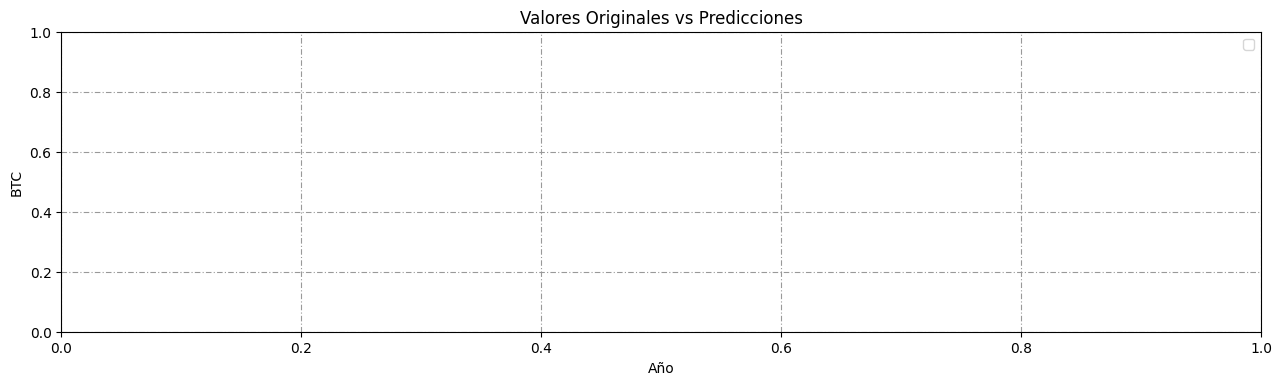

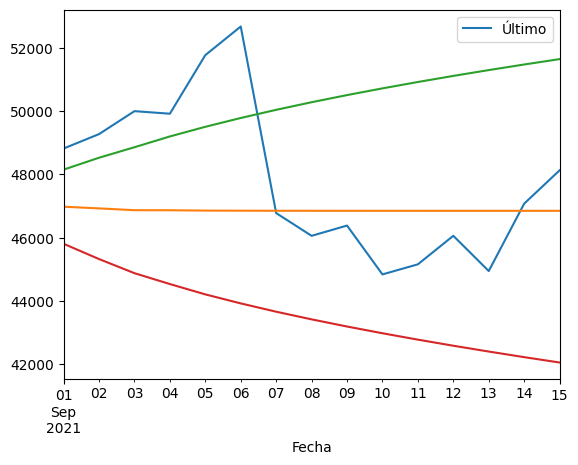

In [161]:
predicciones_arima = modelo_arima.get_forecast(15)

graficar_pred(test[:15], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

In [162]:
evaluar_metricas(test[:15], predicciones_arima.predicted_mean)

MSE: 6638443.5379776405
MAE: 2020.9151235832944
RMSE: 2576.5177154402877
MAPE: nan


In [163]:
modelo_sarima = SARIMAX(train, order=(4,0,0), seasonal_order=(0,0,0,0))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

c:\Users\Josvaldes\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                 Último   No. Observations:                 3134
Model:               SARIMAX(4, 0, 0)   Log Likelihood              -24483.882
Date:                Sat, 11 Nov 2023   AIC                          48977.765
Time:                        08:45:40   BIC                          49008.015
Sample:                    02-01-2013   HQIC                         48988.621
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9330      0.007    131.848      0.000       0.919       0.947
ar.L2          0.1422      0.009     16.208      0.000       0.125       0.159
ar.L3         -0.0382      0.010     -3.964      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


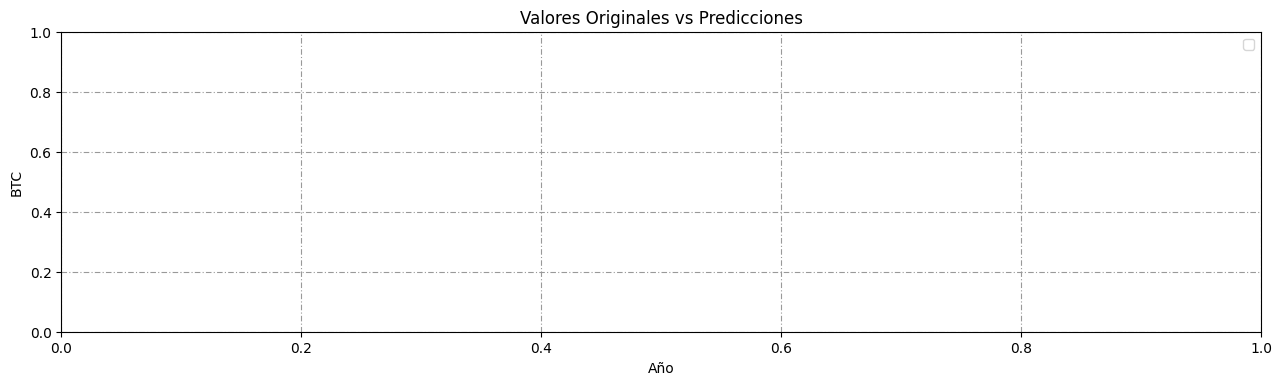

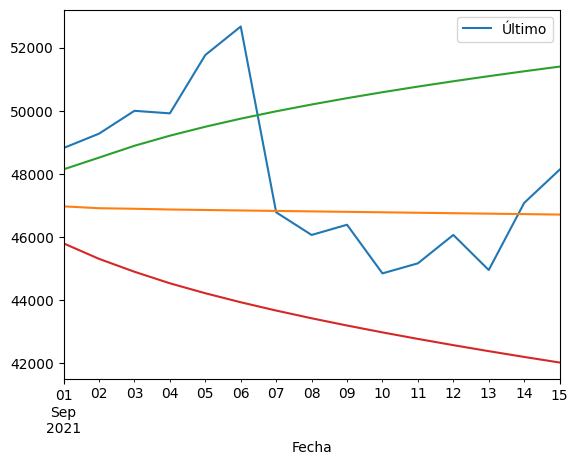

In [164]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 15 días del test
predicciones_sarima = modelo_sarima.get_forecast(15)

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:15], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

In [165]:
evaluar_metricas(test[:15], predicciones_arima.predicted_mean)

MSE: 6638443.5379776405
MAE: 2020.9151235832944
RMSE: 2576.5177154402877
MAPE: nan


In [166]:
#Evaluamos las métricas del modelo
evaluar_metricas(test[:15], predicciones_sarima.predicted_mean )

MSE: 6602250.656458856
MAE: 2007.8071722971154
RMSE: 2569.484511815328
MAPE: nan


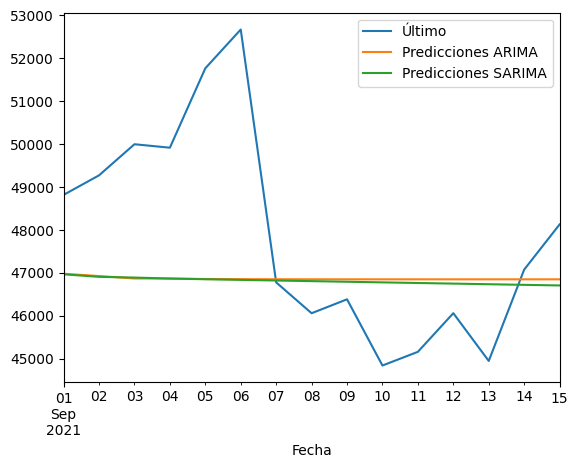

In [167]:
test[:15].plot(label="Serie Original de Test")
predicciones_arima.predicted_mean.plot(label="Predicciones ARIMA")
predicciones_sarima.predicted_mean.plot(label="Predicciones SARIMA")
plt.legend()

In [168]:
datos = {'Modelos': ['SARIMA','ARIMA'],
         'AIC': [modelo_sarima.aic, modelo_arima.aic],
         'BIC': [modelo_sarima.bic, modelo_arima.bic],
         'MAE': [modelo_sarima.mae, modelo_arima.mae],
         'MSE': [modelo_sarima.mse, modelo_arima.mse]}


modelos_residuos = pd.DataFrame(datos)
modelos_residuos

,Modelos,AIC,BIC,MAE,MSE
0,SARIMA,48977.764644,49008.014971,218.575451,356609.109545
1,ARIMA,48951.685751,48981.934483,218.616954,356163.699793


# 7. Validación cruzada de la serie:

In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Datos de series temporales (btc_ts) ya cargados

# Número de divisiones para la validación cruzada
n_splits = 5  # Puedes ajustar este valor según tus necesidades

# Crear un generador de división de series temporales
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para almacenar los resultados
arima_results = []
sarima_results = []

# Iterar a través de las divisiones de validación cruzada
for train_index, test_index in tscv.split(btc_ts):
    train, test = btc_ts.iloc[train_index], btc_ts.iloc[test_index]

    # Ajustar el modelo ARIMA
    arima_model = ARIMA(train, order=(1, 0, 0))  # Ajusta los órdenes según tu configuración
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=len(test))

    arima_mse = mean_squared_error(test, arima_pred)
    arima_results.append(arima_mse)

    # Ajustar el modelo SARIMA
    sarima_model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))  # Ajusta los órdenes según tu configuración
    sarima_fit = sarima_model.fit()
    sarima_pred = sarima_fit.forecast(steps=len(test))

    sarima_mse = mean_squared_error(test, sarima_pred)
    sarima_results.append(sarima_mse)

# Imprimir los resultados
for i, (arima_mse, sarima_mse) in enumerate(zip(arima_results, sarima_results)):
    print(f'Iteración {i + 1}:')
    print(f'ARIMA MSE: {arima_mse}')
    print(f'SARIMA MSE: {sarima_mse}')
    print('---')

c:\Users\Josvaldes\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Josvaldes\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Iteración 1:
ARIMA MSE: 17879.605680304634
SARIMA MSE: 97375.21102334298
---
Iteración 2:
ARIMA MSE: 37850144.73482369
SARIMA MSE: 39483917.00496129
---
Iteración 3:
ARIMA MSE: 16947396.625732455
SARIMA MSE: 15270030.19312781
---
Iteración 4:
ARIMA MSE: 1139499939.509388
SARIMA MSE: 1174692349.4207432
---
Iteración 5:
ARIMA MSE: 166833968.5577993
SARIMA MSE: 164740195.50873357
---


En función de los resultados, se puede observar que el SARIMA tiene MSE más alto en la mayoría de las iteraciones en comparación con ARIMA. Esto puede sugerir que en este caso específico, ARIMA puede ser más adecuado para modelar los datos de series temporales. 